In [1]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

CKPT = "./checkpoints/sam2.1_hiera_large.pt"
CFG  = "configs/sam2.1/sam2.1_hiera_l.yaml"

dev  = "cuda" if torch.cuda.is_available() else "cpu"
sam2 = build_sam2(CFG, CKPT, device=dev).eval()
pred = SAM2ImagePredictor(sam2)

In [40]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/leather/test/color/000.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 3072
final fg masks   = 2
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.048


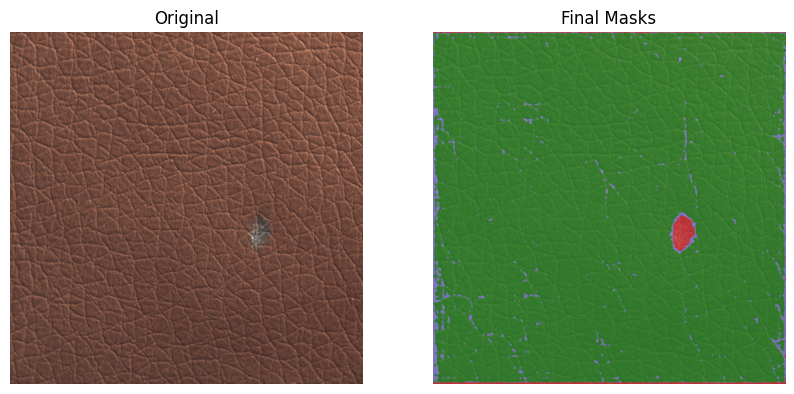

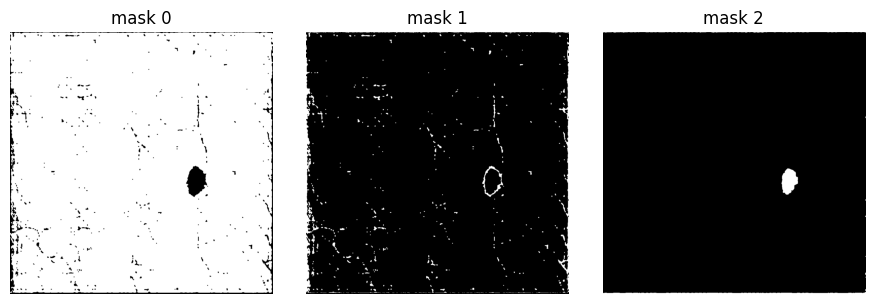

In [41]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True,      
        return_logits    = True
    )                                 

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                  
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                      
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)             
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.sum() >= 1:
        fg_final.append(m); occupied |= m

if occupied.sum() < H * W:     
    bg = ~occupied
    final_masks = fg_final + [bg]
else:
    final_masks = fg_final

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

In [42]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/crack/000.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 3072
final fg masks   = 3
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.000


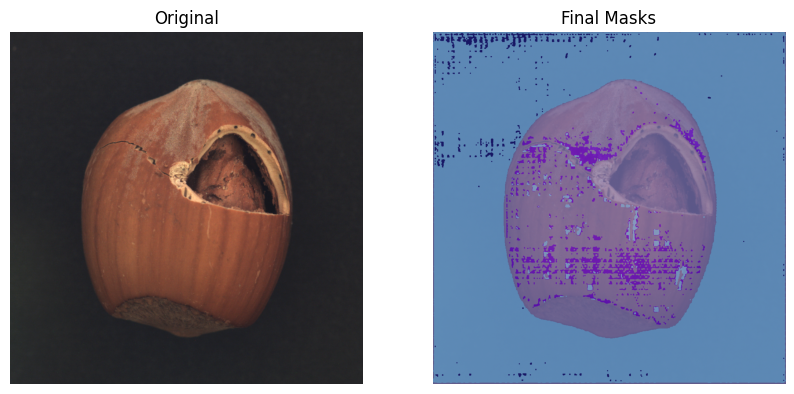

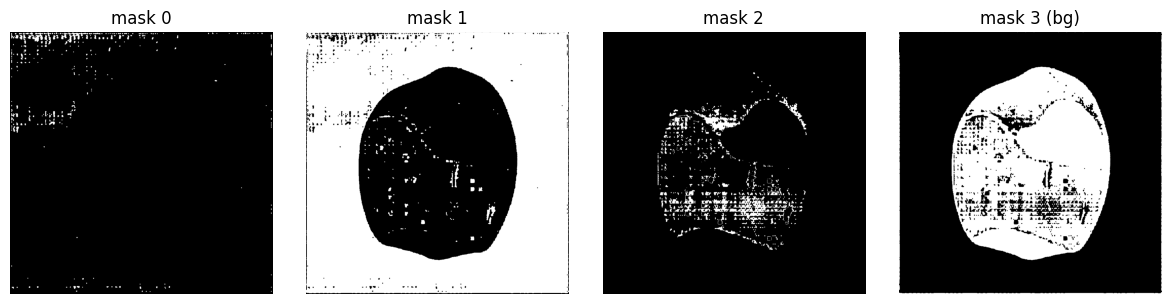

In [45]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True, 
        return_logits    = True
    )                                 

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                   
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                    
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)            
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

bg        = ~occupied
final_masks = fg_final + [bg]              

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

In [32]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/bottle/test/broken_large/002.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 2700
final fg masks   = 2
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.116


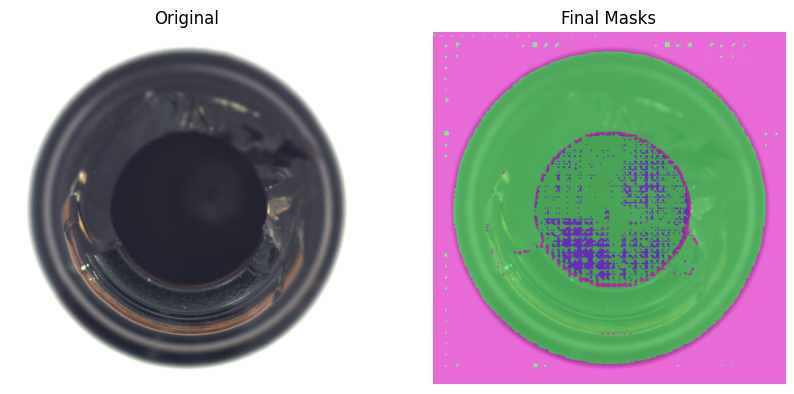

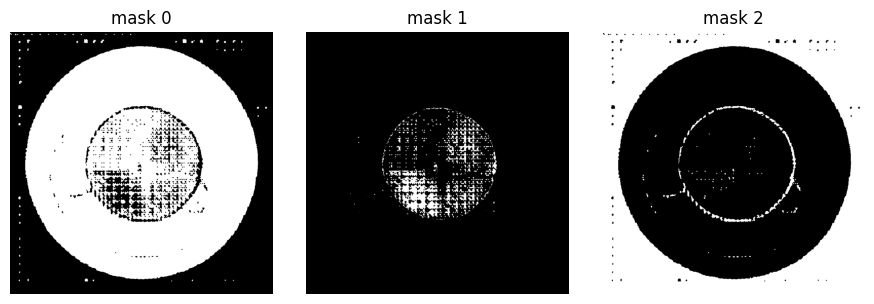

In [34]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True,      
        return_logits    = True
    )                                

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                    
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                     
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)              
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

bg        = ~occupied
final_masks = fg_final + [bg]               

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

In [35]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/zipper/test/broken_teeth/001.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 3072
final fg masks   = 2
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.086


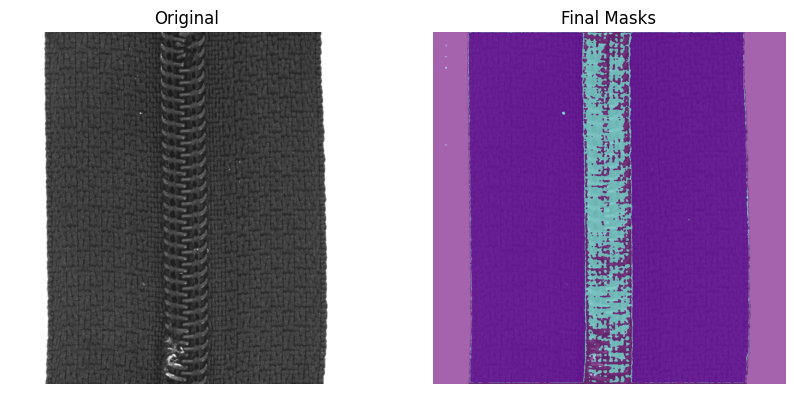

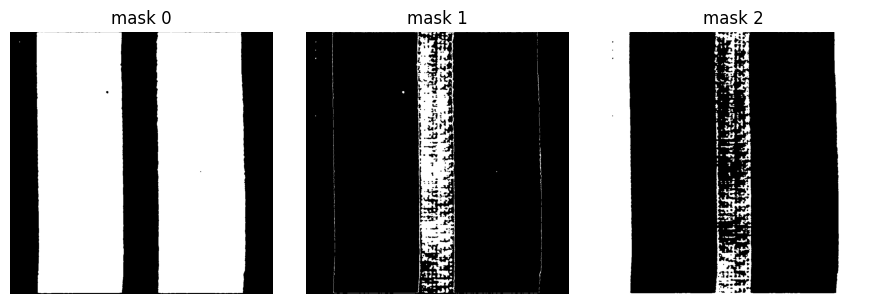

In [37]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True,      
        return_logits    = True
    )                                 

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                    
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                      
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)               
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

bg        = ~occupied
final_masks = fg_final + [bg]               

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

# # 중복되는 영역을 삭제하는 코드를 작성함으로써 중복이 없다는 것을 증명

In [1]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

CKPT = "./checkpoints/sam2.1_hiera_large.pt"
CFG  = "configs/sam2.1/sam2.1_hiera_l.yaml"

dev  = "cuda" if torch.cuda.is_available() else "cpu"
sam2 = build_sam2(CFG, CKPT, device=dev).eval()
pred = SAM2ImagePredictor(sam2)

In [2]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/zipper/test/broken_teeth/001.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

In [4]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    masks, scores, logits = pred.predict(
        point_coords    = points,
        point_labels    = labels,
        multimask_output= True,    
        return_logits   = True
    )                              
print(f"SAM2 raw candidates = {masks.size//(H*W)}")  

SAM2 raw candidates = 3


In [ ]:
keep   = scores.flatten() >= 0.90          
masks  = masks.reshape(-1, H, W)[keep]     
scores_f = scores.flatten()[keep]          

top3    = np.argsort(-scores_f)[:3]
fg_raw  = bin_m[top3]                      
areas   = fg_raw.sum((1,2))
order   = np.argsort(areas)               
occupied= np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

if occupied.sum() < H*W:                   
    bg = ~occupied
    final_masks = fg_final + [bg]
else:
    final_masks = fg_final

print(f"final fg masks = {len(fg_final)},  background added {len(final_masks)==4}")

fg_stack = np.stack(fg_final)
flat_fg  = fg_stack.reshape(len(fg_final), -1)
inter    = (flat_fg[:,None,:] & flat_fg[None,:,:]).sum(-1)
area_fg  = flat_fg.sum(-1, keepdims=True)
iou_fg   = inter / (area_fg + area_fg.T - inter + 1e-6); np.fill_diagonal(iou_fg,0)

coverage = np.stack(final_masks).sum() / (H*W)
print(f"coverage = {coverage:.3f}, mean FG-overlap = {iou_fg.mean():.6f}")

palette = np.random.randint(0,255,(len(final_masks),3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks"); plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i,m in enumerate(final_masks):
    plt.subplot(1,len(final_masks),i+1)
    plt.imshow(m,cmap='gray')
    plt.title(f"mask {i}{' (bg)' if len(final_masks)==4 and i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()